In [41]:
from Triangulation import *

import torch
import torch.optim as optim



from matplotlib import pyplot as plt

import torch.nn as nn
from torch.autograd import Variable

from  Neural_network import *

%matplotlib qt


In [42]:
def get_set_nb_of_points(point_coordinates):
    set_of_numbers=set()
    for index,_ in enumerate(point_coordinates):
        set_of_numbers.add(len(point_coordinates[index][0]))
    return set_of_numbers


def get_indices_nb_of_points(set_of_numbers,number_of_points,point_coordinates):
    indices=[]
    if number_of_points not in set_of_numbers:
        return "No such number of points for sample"
    else:
        for index,_ in enumerate(point_coordinates):
            if len(point_coordinates[index][0])==number_of_points:
                indices.append(index)
        return indices
    
def get_polygons_nb_of_points(indices):
    pass



In [43]:
polygons=load_dataset('12_polygons.pkl')
polygons=[i for i in polygons for j in range(10)]
polygons_reshaped=[]
for polygon in polygons:
    polygons_reshaped.append(polygon.reshape(2,12))

polygons_reshaped=np.array(polygons_reshaped)
#polygons_reshaped=polygons_reshaped.reshape(60000,24)

In [6]:
point_coordinates=load_dataset('12_point_coordinates')
number_of_insertion_points=load_dataset('12_nb_of_points.pkl')
centers_of_mass=load_dataset('12_centers_of_mass')

In [7]:
set_of_points=get_set_nb_of_points(point_coordinates)        
indices=get_indices_nb_of_points(set_of_points,1,point_coordinates)
indices=np.asarray(indices)
number_of_insertion_points=np.array(number_of_insertion_points)

In [8]:
polygons_reshaped.resize(len(point_coordinates),2*12)

polygons_reshaped=np.hstack([polygons_reshaped[indices],number_of_insertion_points[indices,1].reshape(len(indices),1) ])
#polygons_reshaped=polygons_reshaped[indices]


In [9]:
point_coordinates=[ point_coordinates[i][0] for i in indices]
point_coordinates=np.array(point_coordinates)
#barycenters,point_coordinates

In [20]:
#len(polygons_reshaped),len(indices)
#point_coordinates.shape
#centers_of_mass=centers_of_mass.reshape(60000,2)

In [10]:
# Project set of polygons in 2d and 3d space #
# Dimensionality reduction using Isomap, PCA, kernel PCA ... #
from sklearn.decomposition import PCA,KernelPCA

Polygons_reshaped=[]





                        # Isomap #
#nb_components=8
#iso=manifold.Isomap(n_neighbors=8,n_components=nb_components,n_jobs=-1)
#iso.fit(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)


                        # PCA   #
pca=PCA(.999)
pca.fit(polygons_reshaped)
Polygons_projected=pca.transform(polygons_reshaped)
nb_components=int(pca.n_components_)
print(nb_components)
# Fitting into lesser dimension

#Polygons_projected=iso.fit_transform(Polygons_reshaped)
#Polygons_projected=iso.transform(Polygons_reshaped)

#iso = KernelPCA(n_components=2,kernel="rbf", fit_inverse_transform=True, gamma=1e-1)







22


In [17]:
nb_of_test_data=int(len(polygons_reshaped)*0.2)
nb_of_training_data=int(len(polygons_reshaped)-nb_of_test_data)


In [18]:
x_tensor=torch.from_numpy(Polygons_projected[:nb_of_training_data]).type(torch.FloatTensor)
x_tensor_test=torch.from_numpy(Polygons_projected[nb_of_training_data:]).type(torch.FloatTensor)
x_variable,x_variable_test=Variable(x_tensor),Variable(x_tensor_test)

y_tensor=torch.from_numpy(point_coordinates[:nb_of_training_data]).type(torch.FloatTensor)
y_tensor_test=torch.from_numpy(point_coordinates[nb_of_training_data:]).type(torch.FloatTensor)
y_variable,y_variable_test=Variable(y_tensor),Variable(y_tensor_test)



shuffle=torch.randperm(x_variable.shape[0])
x_variable = x_variable[shuffle]
y_variable=y_variable[shuffle]

In [23]:
my_net=Net(nb_components,1*2,nb_of_hidden_layers=2, nb_of_hidden_nodes=20,batch_normalization=True)

print("Training data length:",x_variable.size()[0])

Training data length: 174978


In [24]:
optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3,weight_decay=0)
#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)
max_distance=0.6108970818704328
loss_func =torch.nn.MSELoss(size_average=False) 
#loss_func=myLossfunction()


In [25]:
if  torch.cuda.is_available():
    loss_func.cuda()
    x_variable , y_variable=x_variable.cuda(), y_variable.cuda()
    x_variable_test,y_variable_test= Variable(x_tensor_test.cuda(),volatile=True),Variable(y_tensor_test.cuda(),volatile=True)
    print("cuda activated")


cuda activated


In [26]:
batch_size=int(x_variable.size()[0]/2 )
nb_of_epochs=13000
my_net.cuda()

# Train the network #
my_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        #loss=loss_func.apply(out, y_variable.narrow(0,b,batch_size).resize(batch_size,2))

        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_net.eval()
        test_loss=loss_func(my_net(x_variable_test),y_variable_test).data[0]
        my_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/(x_variable.size(0)),"Test Loss:",test_loss/x_variable_test.size(0))

Epoch: 0 Training Loss: 0.19334205139360378 Test Loss: 0.18400412994139195
Epoch: 10 Training Loss: 0.11567720410744493 Test Loss: 0.1155488824181602
Epoch: 20 Training Loss: 0.10219234480548983 Test Loss: 0.10353034800129732
Epoch: 30 Training Loss: 0.09842879689696704 Test Loss: 0.09985638432199273
Epoch: 40 Training Loss: 0.09415261757906708 Test Loss: 0.09543940579708074
Epoch: 50 Training Loss: 0.08902548865071609 Test Loss: 0.09023040458941511
Epoch: 60 Training Loss: 0.0835252157146184 Test Loss: 0.08468092700034577
Epoch: 70 Training Loss: 0.0781463029012933 Test Loss: 0.07947207090186655
Epoch: 80 Training Loss: 0.07287419201896095 Test Loss: 0.07417404520834286
Epoch: 90 Training Loss: 0.06853561925463487 Test Loss: 0.0698091776247171
Epoch: 100 Training Loss: 0.06563329289521397 Test Loss: 0.06715303768445387
Epoch: 110 Training Loss: 0.0633043421887323 Test Loss: 0.06487926603148432
Epoch: 120 Training Loss: 0.06125940319104402 Test Loss: 0.06298593717852734
Epoch: 130 Trai

Epoch: 1060 Training Loss: 0.042362782359157296 Test Loss: 0.04639402164886185
Epoch: 1070 Training Loss: 0.04235579766411706 Test Loss: 0.04638987487480426
Epoch: 1080 Training Loss: 0.04234849903452148 Test Loss: 0.04637795080646774
Epoch: 1090 Training Loss: 0.04234091995672313 Test Loss: 0.04637704945517528
Epoch: 1100 Training Loss: 0.04233297252904651 Test Loss: 0.04636428263733312
Epoch: 1110 Training Loss: 0.042324249334202015 Test Loss: 0.04637321243341944
Epoch: 1120 Training Loss: 0.04231662839846295 Test Loss: 0.04636910472721973
Epoch: 1130 Training Loss: 0.042309237681397806 Test Loss: 0.04635572119533536
Epoch: 1140 Training Loss: 0.042300373564819575 Test Loss: 0.04633287207959949
Epoch: 1150 Training Loss: 0.04229117458471565 Test Loss: 0.04630713194238067
Epoch: 1160 Training Loss: 0.04228304577262927 Test Loss: 0.046316491484903646
Epoch: 1170 Training Loss: 0.04227484580204369 Test Loss: 0.046305256685202544
Epoch: 1180 Training Loss: 0.042266663969899074 Test Loss:

Epoch: 2110 Training Loss: 0.04171917187223179 Test Loss: 0.046133137656199995
Epoch: 2120 Training Loss: 0.041718368199770116 Test Loss: 0.046139276891009336
Epoch: 2130 Training Loss: 0.04171665760525966 Test Loss: 0.04613840344532964
Epoch: 2140 Training Loss: 0.041714938639161064 Test Loss: 0.04611666497298201
Epoch: 2150 Training Loss: 0.04171356569870569 Test Loss: 0.046117404471720407
Epoch: 2160 Training Loss: 0.04171236577107194 Test Loss: 0.04612324232591184
Epoch: 2170 Training Loss: 0.04171094260108771 Test Loss: 0.04612422181292006
Epoch: 2180 Training Loss: 0.0417098961525699 Test Loss: 0.0461353784769054
Epoch: 2190 Training Loss: 0.04170851344526169 Test Loss: 0.04611576083112827
Epoch: 2200 Training Loss: 0.0417073470039805 Test Loss: 0.046110269006535184
Epoch: 2210 Training Loss: 0.041706502868842796 Test Loss: 0.04611966203579348
Epoch: 2220 Training Loss: 0.041705647571587574 Test Loss: 0.04612406275092727
Epoch: 2230 Training Loss: 0.04170504760777069 Test Loss: 0

Epoch: 3160 Training Loss: 0.04160073064319157 Test Loss: 0.046081364372828275
Epoch: 3170 Training Loss: 0.04159921817626716 Test Loss: 0.046089593738034076
Epoch: 3180 Training Loss: 0.04159813545086739 Test Loss: 0.04607538978113427
Epoch: 3190 Training Loss: 0.04159664670344272 Test Loss: 0.046083217305516185
Epoch: 3200 Training Loss: 0.0415953100398693 Test Loss: 0.046077488283214556
Epoch: 3210 Training Loss: 0.041593860359855954 Test Loss: 0.046080309540665575
Epoch: 3220 Training Loss: 0.04159144934247091 Test Loss: 0.04609105878270448
Epoch: 3230 Training Loss: 0.041589461090287064 Test Loss: 0.046090788098260616
Epoch: 3240 Training Loss: 0.041586704047258796 Test Loss: 0.04607558512042366
Epoch: 3250 Training Loss: 0.04158470323769274 Test Loss: 0.04607887798273049
Epoch: 3260 Training Loss: 0.04158285590724262 Test Loss: 0.04607386613467704
Epoch: 3270 Training Loss: 0.04158138111246485 Test Loss: 0.04608109368838441
Epoch: 3280 Training Loss: 0.04157972493327733 Test Loss

Epoch: 4210 Training Loss: 0.04125718159479334 Test Loss: 0.045591671098822124
Epoch: 4220 Training Loss: 0.041257174618469894 Test Loss: 0.0455875773454288
Epoch: 4230 Training Loss: 0.04125650628668318 Test Loss: 0.04558798755793652
Epoch: 4240 Training Loss: 0.04125622165268634 Test Loss: 0.045579476346041745
Epoch: 4250 Training Loss: 0.041256504891418494 Test Loss: 0.045577804799836835
Epoch: 4260 Training Loss: 0.04125654814462389 Test Loss: 0.045585537445135334
Epoch: 4270 Training Loss: 0.041255966319247994 Test Loss: 0.04558001213380692
Epoch: 4280 Training Loss: 0.04125564819889858 Test Loss: 0.04558809638982632
Epoch: 4290 Training Loss: 0.04125573610057407 Test Loss: 0.04558347801091293
Epoch: 4300 Training Loss: 0.041255285430079065 Test Loss: 0.04559219572434219
Epoch: 4310 Training Loss: 0.04125541239916589 Test Loss: 0.0456001823107169
Epoch: 4320 Training Loss: 0.04125505381614046 Test Loss: 0.04559022279751938
Epoch: 4330 Training Loss: 0.04125510404566931 Test Loss: 

KeyboardInterrupt: 

In [27]:
contour1=np.delete(polygons_reshaped[311],24)

contour1=polygons[10].reshape(12,2)

In [28]:


nb_of_inserted_points,inserted_point_coordinates=get_extrapoints_target_length(contour1,.9)
inserted_point_coordinates=np.array(inserted_point_coordinates)



13 0.00646368949978321 -0.1199108451461814 0


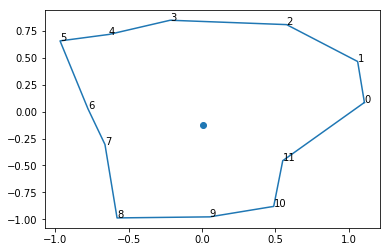

In [29]:
plot_contour(contour1)
plt.scatter(inserted_point_coordinates[:,0],inserted_point_coordinates[:,1])

In [30]:
my_net.eval()
#torch.cuda.empty_cache()

Net(
  (bn_input): BatchNorm1d(22, eps=1e-05, momentum=0.5, affine=True)
  (fc0): Linear(in_features=22, out_features=20, bias=True)
  (bn0): BatchNorm1d(20, eps=1e-05, momentum=0.5, affine=True)
  (predict): Linear(in_features=20, out_features=2, bias=True)
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.5, affine=True)
)

In [31]:
predictions=my_net(x_variable).cpu()

In [32]:
predicted_inserted_points=predictions.data.numpy()[10]

In [33]:
predicted_inserted_points=predicted_inserted_points.reshape(1,2)

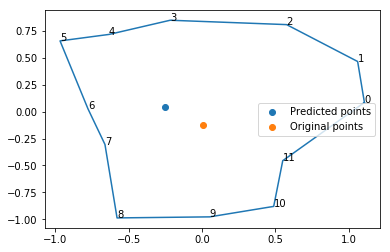

In [34]:
plt.scatter(predicted_inserted_points[:,0],predicted_inserted_points[:,1],label='Predicted points')
plt.scatter(inserted_point_coordinates[:,0],inserted_point_coordinates[:,1],label='Original points')
#plt.scatter(polygons_reshaped[3112][0::2].sum()/12,polygons_reshaped[312][1::2].sum()/12,label='Original points')
plot_contour(contour1)
plt.legend()
original_points=point_coordinates.reshape(218722,2)
#plt.scatter(original_points[:,0],original_points[:,1],label='Original points')


distances=[np.linalg.norm(i-j) for i in centers_of_mass for j in predicted_inserted_points]
distances=np.array(distances)
100*distances.sum()/(x_variable.size(0) *max_distance)

In [35]:
x_variable,x_variable_test=x_variable.resize(x_variable.size()[0],1,25),Variable(x_tensor_test.view(x_variable_test.size()[0],1,25),volatile=True)

In [36]:
# Using convolution network
# O: output dimension
# I: Input dimensiion
# S: Stride
# P: padding
# w: kernel size
# O=(I-w-2*P)/S+1


class Conv_net(nn.Module):
    
    def __init__(self):
        super(Conv_net,self).__init__()
        self.conv1=nn.Conv1d(1,14,kernel_size=14,stride=1)
        self.conv2=nn.Conv1d(14,28,kernel_size=2,stride=1)

        self.bn1=nn.BatchNorm1d(num_features=28*10)
        self.fc1=nn.Linear(28*10,12)
        
        self.bn2=nn.BatchNorm1d(num_features=12)
        self.fc2=nn.Linear(12,12)
        
        self.bn3=nn.BatchNorm1d(num_features=12)
        self.fc3=nn.Linear(12,12)
        
        
        self.bn4=nn.BatchNorm1d(num_features=12)
        self.fc4=nn.Linear(12,2)
        
    def forward(self,x):
        x=self.conv1(x)

        x=F.relu(x)
        #x=self.conv2(x)

        x=F.relu(F.max_pool1d(self.conv2(x),kernel_size=2,stride=1))
        x=F.relu(self.fc1(self.bn1(x.view(-1,28*10))))
        x=F.relu(self.fc2(self.bn2(x)))
        x=F.relu(self.fc3(self.bn3(x)))

        x=self.fc4(self.bn4(x))

        return x
    
        

In [37]:
torch.cuda.empty_cache()
my_conv_net=Conv_net()


In [38]:
optimizer = torch.optim.Adam(my_conv_net.parameters(), lr=1e-3,weight_decay=0)

#optimizer = torch.optim.SGD(my_net.parameters(), lr=1e-5,weight_decay=.5,momentum=0.9)

#loss_func = torch.nn.MSELoss(size_average=False) 
#loss_func=torch.nn.SmoothL1Loss()


In [39]:
if  torch.cuda.is_available():
    loss_func.cuda()
    my_conv_net.cuda()
    x_variable , y_variable,x_variable_test,y_variable_test= x_variable.cuda(), y_variable.cuda(),x_variable_test.cuda(),y_variable_test.cuda()
    print("cuda activated")


cuda activated


In [40]:

batch_size=int(x_variable.size()[0]/18 )
nb_of_epochs=13000
# Train the network #
my_conv_net.train()
for t in range(nb_of_epochs):
    sum_loss=0
    for b in range(0,x_variable.size(0),batch_size):
        out = my_conv_net(x_variable.narrow(0,b,batch_size))                 # input x and predict based on x
        loss = loss_func(out, y_variable.narrow(0,b,batch_size))     # must be (1. nn output, 2. target), the target label is NOT one-hotted
        #loss=loss_func.apply(out, y_variable.narrow(0,b,batch_size))
        #loss=torch.sqrt((out[0]-y_variable.narrow(0,b,batch_size)[0]).pow(2)+(out[1]-y_variable.narrow(0,b,batch_size)[1]).pow(2)) 
        sum_loss+=loss.data[0]
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        #print(t,loss.data[0])
        optimizer.step()        # apply gradients
    if t%10==0:
        my_conv_net.eval()
        test_loss=loss_func(my_conv_net(x_variable_test),y_variable_test).data[0]
        my_conv_net.train()
        print("Epoch:",t,"Training Loss:",sum_loss/x_variable.size(0),"Test Loss:",test_loss/x_variable_test.size(0))

RuntimeError: invalid argument 2: size '[-1 x 280]' is invalid for input with 1905316 elements at C:\Anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\TH\THStorage.c:37

In [50]:
x_variable=x_variable.cpu()
my_conv_net=my_conv_net.cpu()

found 1 extra points
13 -0.1925145994756827 -0.0867447465103373 0


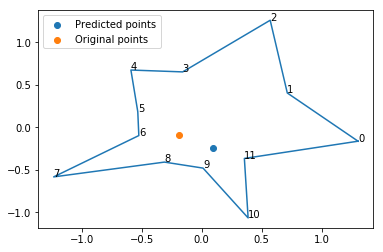

In [53]:
contour1=np.delete(polygons_reshaped[15],24)
contour1=contour1.reshape(12,2)
nb_of_inserted_points,inserted_point_coordinates=get_extrapoints_target_length(contour1,.4
                                                                              )
inserted_point_coordinates=np.array(inserted_point_coordinates)
my_conv_net.eval()
predictions=my_conv_net(x_variable).cpu()
predicted_inserted_points=predictions.data.numpy()[15]
predicted_inserted_points=predicted_inserted_points.reshape(1,2)
plt.scatter(predicted_inserted_points[:,0],predicted_inserted_points[:,1],label='Predicted points')
plt.scatter(inserted_point_coordinates[:,0],inserted_point_coordinates[:,1],label='Original points')

plot_contour(contour1)
plt.legend()

In [462]:
predicted_inserted_points

array([[ 0.09719837, -0.23911646]], dtype=float32)

In [747]:
d_tensor=torch.FloatTensor([2.2,1.2])
a_tensor=torch.FloatTensor([1,2])

In [748]:
d_variable=Variable(d_tensor)

a_variable=Variable(a_tensor)

In [749]:
d_variable.requires_grad=False
a_variable.requires_grad=True

In [750]:
fun=torch.sqrt((a_variable[0]-d_variable[0]).pow(2)+(a_variable[1]-d_variable[1]).pow(2))
fun

Variable containing:
 1.4422
[torch.FloatTensor of size 1]

In [692]:
fun.backward()

In [693]:
a_variable.grad

Variable containing:
-0.8321
 0.5547
[torch.FloatTensor of size 2]

In [694]:
a_variable.grad.zero_()

Variable containing:
 0
 0
[torch.FloatTensor of size 2]

In [812]:
from torch.autograd.function import Function
from math import pow

class myLossfunction(Function):
    
    @staticmethod
    def forward(self,output,target):
        self.save_for_backward(output,target) 

                        
       # output=output.view(int(output.size()[0]/2),2)

        #target=target.view(int(target.size()[0]/2),2)
        distance=torch.nn.PairwiseDistance()
        result=distance(output,target)

        result=torch.FloatTensor(result)
        #self.save_for_backward(result)


        return  result 
    
    
    @staticmethod
    def backward(self,grad_output1):
        input1,target=self.saved_variables
        
        print(input1)
        #distance=torch.nn.PairwiseDistance()(input1.view(int(input1.size()[0]/2),2),target.view(int(target.size()[0]/2),2))
        distance=torch.nn.PairwiseDistance()(input1,target)

        grad_output1=(input1-target)/distance

        
        return grad_output1,None
    

In [813]:
myloss=myLossfunction().apply(out,y_variable.narrow(0,b,batch_size).resize(batch_size,2))
myloss

Variable containing:
 0.2042
 0.4508
 0.6575
   ⋮    
 0.3220
 0.1622
 1.0774
[torch.FloatTensor of size 9721x1]

In [814]:
myloss.backward(torch.Tensor([1, 1]))


Variable containing:
-2.3953e-01 -1.6375e-01
-1.9727e-01 -3.8089e-01
-4.1456e-01 -9.3787e-02
           ⋮            
-7.2860e-02 -6.4023e-02
-1.8527e-01 -2.7595e-01
-2.6488e-01 -8.1565e-01
[torch.FloatTensor of size 9721x2]



In [754]:
a_variable.grad

Variable containing:
-0.8320  0.5547
[torch.FloatTensor of size 1x2]

In [634]:
myLossfunction.backward()

TypeError: backward() missing 2 required positional arguments: 'self' and 'grad_output1'

In [635]:
a_variable.grad

Variable containing:
 0
 0
[torch.FloatTensor of size 2]

In [636]:
# Flush all variables in GPU
del my_conv_net,my_net,x_variable_test,x_variable,y_variable,y_variable_test,loss_func
torch.cuda.empty_cache()


In [ ]:
point_coordinates

In [68]:
p2dust=torch.nn.PairwiseDistance(p=2)

In [69]:
p2dust(a_variable.resize(2,2),d_variable.resize(2,2))

Variable containing:
 1.4422
 2.2472
[torch.FloatTensor of size 2x1]

In [70]:
point_coordinates

array([[[ 0.09185446,  0.06111541]],

       [[ 0.09185446,  0.06111541]],

       [[ 0.09185446,  0.06111541]],

       ...,

       [[ 0.29833109, -0.19828089]],

       [[ 0.29833109, -0.19828089]],

       [[ 0.29833109, -0.19828089]]])

In [71]:
x_variable

Variable containing:
(  0   ,.,.) = 
  5.4394e-01 -1.2854e-01  1.2081e+00  ...   8.7166e-01 -3.9516e-01  4.0000e-01

(  1   ,.,.) = 
  8.0653e-01 -7.0666e-02  7.9998e-01  ...   1.0453e+00 -4.1684e-01  4.0000e-01

(  2   ,.,.) = 
  5.0649e-01  6.8832e-02  9.6722e-01  ...   8.5345e-01 -5.3134e-01  3.0000e-01
  ...  

(174975,.,.) = 
  1.1163e+00 -3.1378e-02  7.0993e-01  ...   7.3510e-01 -6.3782e-01  5.0000e-01

(174976,.,.) = 
  7.6960e-01 -4.1094e-02  7.8531e-01  ...   9.1110e-01 -3.1011e-01  9.0000e-01

(174977,.,.) = 
  1.2754e+00 -3.7225e-01  7.9667e-01  ...   5.6758e-01 -2.6036e-01  5.0000e-01
[torch.FloatTensor of size 174978x1x25]

In [ ]:
'''
Should I order the interior points ?

For each interior point calculate distance with points of the polygon

find which ti which point it is closer and sort it according to the index.

If multiple points are closer to the same point of the contour then take into

account the distance to the point.

'''

In [768]:
 output_reshaped=out.view(int(out.size()[0]/2),2)

RuntimeError: invalid argument 2: size '[4860 x 2]' is invalid for input with 19442 elements at C:\Anaconda2\conda-bld\pytorch_1519501749874\work\torch\lib\TH\THStorage.c:41

In [790]:
out,y_variable.narrow(0,b,batch_size).resize(batch_size,2)

(Variable containing:
 -1.4947e-01 -2.7472e-01
 -1.9165e-01 -2.2482e-01
 -1.3642e-01 -3.2461e-01
            ⋮            
 -3.8810e-02 -2.6062e-01
 -1.4880e-01 -2.9060e-01
 -1.3283e-01 -3.1349e-01
 [torch.FloatTensor of size 9721x2], Variable containing:
 -0.2311  0.0403
  0.1704 -0.1201
  0.2371 -0.1810
        ⋮        
 -0.0681  0.2579
 -0.1204 -0.1273
 -0.0528  0.2407
 [torch.FloatTensor of size 9721x2])

In [789]:
y_variable,out

(Variable containing:
 (  0   ,.,.) = 
  -0.2311  0.0403
 
 (  1   ,.,.) = 
   0.1704 -0.1201
 
 (  2   ,.,.) = 
   0.2371 -0.1810
   ...  
 
 (174975,.,.) = 
  -0.1804  0.0393
 
 (174976,.,.) = 
   0.2417  0.0188
 
 (174977,.,.) = 
   0.2496 -0.1190
 [torch.FloatTensor of size 174978x1x2], Variable containing:
 -1.4947e-01 -2.7472e-01
 -1.9165e-01 -2.2482e-01
 -1.3642e-01 -3.2461e-01
            ⋮            
 -3.8810e-02 -2.6062e-01
 -1.4880e-01 -2.9060e-01
 -1.3283e-01 -3.1349e-01
 [torch.FloatTensor of size 9721x2])

In [839]:
polygons[0][:,0].sum()/12

-1.0177044392397268e-16

In [826]:
def get_barycenters(polygons):
    
    for polygon 

SyntaxError: invalid syntax (<ipython-input-826-db58e474dc7f>, line 2)

In [864]:
polygons_reshaped[0][0::2].sum()

array([ 0.72589751,  0.84207899,  0.71337615,  0.16721335, -0.53593486,
       -1.19396456, -0.99666214, -0.86514855, -0.06646145,  0.05744332,
        0.52287723,  0.62928501])

In [865]:
polygons_reshaped[0][1::2]

array([ 0.17159901,  0.40510667,  0.63783057,  0.58156785,  0.85478697,
        0.50564378,  0.37817729, -0.73118862, -0.53079973, -1.1159677 ,
       -0.86178872, -0.29496737])

In [19]:
polygons_reshaped

array([[ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       [ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       [ 0.72589751,  0.17159901,  0.84207899, ..., -0.86178872,
         0.62928501, -0.29496737],
       ...,
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ],
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ],
       [ 0.94168403, -0.21109   ,  0.66819129, ..., -0.98049631,
         0.94108807, -0.3414368 ]])

In [7]:
barycenters=[np.array([i[0::2].sum()/12,i[1::2].sum()/12]) for i in polygons_reshaped]

In [8]:
barycenters=np.array(barycenters)

In [12]:
len(point_coordinates)

218722

In [26]:
polygons_reshaped.shape

(218722, 24)

In [43]:
point_coordinates=point_coordinates.reshape(len(point_coordinates),2)

In [45]:
polygons_with_points=np.hstack([polygons_reshaped,point_coordinates])


In [48]:
polygons_with_points=polygons_with_points.reshape(len(polygons_with_points),13,2)

In [49]:
polygons_with_points

array([[[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       [[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       [[ 0.72589751,  0.17159901],
        [ 0.84207899,  0.40510667],
        [ 0.71337615,  0.63783057],
        ...,
        [ 0.52287723, -0.86178872],
        [ 0.62928501, -0.29496737],
        [ 0.09185446,  0.06111541]],

       ...,

       [[ 0.94168403, -0.21109   ],
        [ 0.66819129,  0.35508194],
        [ 0.41427257,  0.62051448],
        ...,
        [ 0.46430839, -0.98049631],
        [ 0.94108807, -0.3414368 ],
        [ 0.29833109, -0.19828089]],

       [[ 0.94168403, -0.21109   ],
        [ 0.66819129,  0.35

In [52]:
polygons_with_points_unique=list(set(polygons_with_points))

TypeError: unhashable type: 'numpy.ndarray'

(60000, 2, 12)

In [68]:
centers_of_mass=np.array(centers_of_mass)


In [106]:
centers_of_mass.shape

(60000, 2)

In [107]:
x_variable

Variable containing:
(  0  ,.,.) = 
  1.0804e+00  3.6440e-01  6.1404e-01  ...   4.9729e-01 -1.0542e+00  8.4189e-01
 -1.1037e+00 -1.0409e-01 -5.6104e-01  ...  -1.1438e+00  7.8898e-01 -5.4535e-01

(  1  ,.,.) = 
  8.2030e-01 -9.6631e-02  1.1965e+00  ...   7.3245e-01 -1.1246e+00  6.5850e-01
 -9.8128e-01 -1.1748e-01 -4.0551e-01  ...  -7.3543e-01  5.2845e-01 -3.5533e-01

(  2  ,.,.) = 
  8.8570e-01 -9.5701e-02  1.2094e+00  ...   5.8753e-01 -7.4392e-01  6.8171e-01
 -1.2722e+00 -1.4492e-01 -1.0465e+00  ...  -5.5213e-01  6.8863e-01 -5.0008e-01
 ...  

(47997,.,.) = 
  1.0355e+00 -1.4388e-01  8.2466e-01  ...   7.1425e-01 -8.3453e-01  3.6346e-01
 -7.5888e-01  6.7694e-02 -8.8216e-01  ...  -1.0865e+00  3.7439e-01 -3.2188e-01

(47998,.,.) = 
  6.8633e-01  5.9241e-02  9.9623e-01  ...   1.1396e+00 -7.3713e-01  8.0244e-02
 -8.3097e-01 -2.3101e-01 -8.2566e-01  ...  -7.4034e-01  6.7384e-01 -5.5374e-01

(47999,.,.) = 
  8.7795e-01  6.0293e-02  8.4823e-01  ...   7.8716e-01 -7.3494e-01  3.3091e-01
 -1.1220

In [77]:
contour3=apply_procrustes(generate_contour(12))
plot_contour(contour3)

In [100]:
inserted_points=[]
nb_of_sampling=100
contour=contour3.copy()
plot_contour(contour3)

for i in range(0,nb_of_sampling):
    contour[0]=np.random.normal(contour3[0],0.08)
    contour[11]=np.random.normal(contour3[11],0.08)

    nb_of_points,point_coords=get_extrapoints_target_length(contour,0.2)
    inserted_points.append(point_coords)
    plt.scatter(contour[0][0],contour[0][1])
    plt.scatter(contour[11][0],contour[11][1])


inserted_points=[i for i in inserted_points if len(i)==1]
inserted_points=np.array(inserted_points)
inserted_points=inserted_points.reshape(len(inserted_points),2)

plt.scatter(inserted_points[:,0],inserted_points[:,1])

13 -0.1397529684620565 -0.03668817911622362 0
14 -0.5556838673885416 0.006489134426013973 0
13 -0.1506273310219623 -0.02890481750650344 0
14 -0.5584024580285181 0.008434974828444014 0
13 -0.1355795824036162 -0.0391512743253334 0
14 -0.5546405208739316 0.005873360623736529 0
13 -0.1606318248853285 -0.1507826396315696 0
13 -0.1029359385443222 -0.01988941712108101 0
14 -0.546479609909108 0.01068882492479963 0
13 -0.1469844471794247 -0.05733317507392088 0
14 0.7059926839926042 0.1405732385547066 0
15 -0.5574917370678837 0.001327885436589659 0
13 -0.06406265062238639 -0.0485721250445643 0
13 -0.1236015407066197 -0.04107046060343363 0
14 -0.5516460104496824 0.00539356405421147 0
13 -0.14404267783239 -0.03219865149111428 0
14 -0.556756294731125 0.00761151633229131 0
13 -0.1415910047281703 -0.02934662034552328 0
14 -0.5561433764550701 0.008324524118689058 0
13 -0.1393203257012531 -0.04295809812348142 0
14 -0.5555757066983406 0.004921654674199518 0
13 -0.05551841490555372 -0.04630404540602545 0